In [3]:
from functools import partial
from pathlib import Path

from matplotlib.pyplot import plot
from torch import Generator, tensor, use_deterministic_algorithms

from karpathy_series.makemore.bigrams import NGram
from karpathy_series.makemore.data import read_data
from karpathy_series.makemore.encoding.character import CharacterEncoder, CharacterSet, StringEncoder
from karpathy_series.makemore.components.generation import NGramNetGenerator
from karpathy_series.makemore.components.networks.mlp_flat import MLPNet
from karpathy_series.makemore.components.models.model import Model
from karpathy_series.makemore.components.function.loss import CrossEntropyLoss
from karpathy_series.makemore.training.data import TrainingSequencer
from karpathy_series.makemore.training.learning import Learner, LearningRecord

%matplotlib inline
use_deterministic_algorithms(True)
rand_generator = Generator()
seed = 2147483647


def create_generator():
    return rand_generator.manual_seed(seed)

In [4]:
data_path = Path("../../data/names.txt")
words = read_data(data_path)
char_set = CharacterSet.from_words(words)
char_encoder = CharacterEncoder.from_charset(char_set)
string_encoder = StringEncoder(char_encoder)

context_size = 4
n_gram_gen = partial(NGram.generate, context_size, char_set.pad)
ts = TrainingSequencer(string_encoder, char_encoder, n_gram_gen)

embedding_dims = 10
hidden_dims = 200

In [5]:
import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xis_d, yis_d = ts.training_set(words[n1:n2])
xis_v, yis_v = ts.training_set(words[n2:])

learning_sequence = ts.training_sequence(words[:n1], 32, True)

In [6]:
g = rand_generator.manual_seed(seed)
mpl_net = MLPNet.init_normalized_from_size(char_encoder.size, context_size, embedding_dims, hidden_dims, generator=g)
model = Model(mpl_net, CrossEntropyLoss())
generator = NGramNetGenerator(char_set, string_encoder, char_encoder, mpl_net, context_size)
losses = LearningRecord()

In [7]:
learner = Learner(model, 0.1)
losses += learner(learning_sequence, epochs=10, report_epochs=1)

Epoch 1 is finished with loss =  2.3286
Epoch 2 is finished with loss =  2.2263
Epoch 3 is finished with loss =  2.3636
Epoch 4 is finished with loss =  2.2386
Epoch 5 is finished with loss =  2.2043
Epoch 6 is finished with loss =  2.2273
Epoch 7 is finished with loss =  2.2031
Epoch 8 is finished with loss =  2.3030
Epoch 9 is finished with loss =  2.2103
Epoch 10 is finished with loss =  2.0488


In [8]:
print(model(xis_v, yis_v))

tensor(2.1760, grad_fn=<NllLossBackward0>)


In [9]:
for k in range(20):
    print(generator())

janellley
jamitr
sana
joan
lavian
metsa
aais
elis
andar
elli
karo
perrison
jayne
mulaenen
narlyn
tylen
amury
canviny
prinna
umethondespab


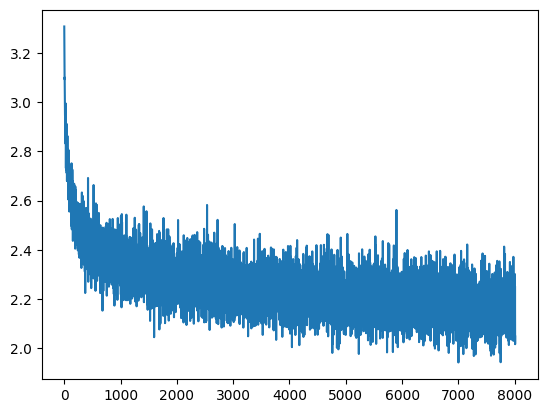

In [10]:
plot(tensor(losses.loss))